# Initial stuff

In [1]:
!pip install ultralytics

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Binary masks to YOLO format

# bin to coco/json

In [ ]:
# https://youtu.be/NYeJvxe5nYw
"""
This code automates the conversion of binary masks representing different
object categories into the COCO (Common Objects in Context) JSON format.

The code is based on the following folder structure for training and validation
images and masks. You need to change the code based on your folder structure
or organize your data to the format below.

EM-platelet-multi/   #Primary data folder for the project
├── input/           #All input data is stored here.
│   ├── train_images/
│   │   ├── image01.png
│   │   ├── image02.png
│   │   └── ...
│   ├── train_masks/        #All binary masks organized in respective sub-directories.
│   │   ├── Alpha/
│   │   │   ├── image01.png
│   │   │   ├── image02.png
│   │   │   └── ...
│   │   ├── Cells/
│   │   │   ├── image01.png
│   │   │   ├── image02.png
│   │   │   └── ...
│   │   ├── Mito/
│   │   │   ├── image01.png
│   │   │   ├── image02.png
│   │   │   └── ...
│   │   └── Vessels/
│   │       ├── image01.png
│   │       ├── image02.png
│   │       └── ...
│   ├── val_images/
│   │   ├── image05.png
│   │   ├── image06.png
│   │   └── ...
│   └── val_masks/
│       ├── Alpha/
│       │   ├── image05.png
│       │   ├── image06.png
│       │   └── ...
│       ├── Cells/
│       │   ├── image05.png
│       │   ├── image06.png
│       │   └── ...
│       ├── Mito/
│       │   ├── image05.png
│       │   ├── image06.png
│       │   └── ...
│       └── Vessels/
│           ├── image05.png
│           ├── image06.png
│           └── ...
└── ...


For each binary mask, the code extracts contours using OpenCV.
These contours represent the boundaries of objects within the images.This is a key
step in converting binary masks to polygon-like annotations.

Convert the contours into annotations, including
bounding boxes, area, and segmentation information. Each annotation is
associated with an image ID, category ID, and other properties required by the COCO format.

The code also creates an images section containing
metadata about the images, such as their filenames, widths, and heights.
In my example, I have used exactly the same file names for all images and masks
so that a given mask can be easily mapped to the image.

All the annotations, images, and categories are
assembled into a dictionary that follows the COCO JSON format.
This includes sections for "info," "licenses," "images," "categories," and "annotations."

Finally, the assembled COCO JSON data is saved to a file,
making it ready to be used with tools and frameworks that support the COCO data format.


"""

import glob
import json
import os
import cv2

# Label IDs of the dataset representing different categories
category_ids = {
    "Cornea": 1,
}

MASK_EXT = 'png'
ORIGINAL_EXT = 'png'
image_id = 0
annotation_id = 0

def images_annotations_info(maskpath):
    """
    Process the binary masks and generate images and annotations information.

    :param maskpath: Path to the directory containing binary masks
    :return: Tuple containing images info, annotations info, and annotation count
    """
    global image_id, annotation_id
    annotations = []
    images = []

    # Iterate through categories and corresponding masks
    for category in category_ids.keys():
        for mask_image in glob.glob(os.path.join(maskpath, category, f'*.{MASK_EXT}')):
            original_file_name = f'{os.path.basename(mask_image).split(".")[0]}.{ORIGINAL_EXT}'
            mask_image_open = cv2.imread(mask_image)

            # Get image dimensions
            height, width, _ = mask_image_open.shape

            # Create or find existing image annotation
            if original_file_name not in map(lambda img: img['file_name'], images):
                image = {
                    "id": image_id + 1,
                    "width": width,
                    "height": height,
                    "file_name": original_file_name,
                }
                images.append(image)
                image_id += 1
            else:
                image = [element for element in images if element['file_name'] == original_file_name][0]

            # Find contours in the mask image
            gray = cv2.cvtColor(mask_image_open, cv2.COLOR_BGR2GRAY)
            _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]

            # Create annotation for each contour
            for contour in contours:
                bbox = cv2.boundingRect(contour)
                area = cv2.contourArea(contour)
                segmentation = contour.flatten().tolist()

                annotation = {
                    "iscrowd": 0,
                    "id": annotation_id,
                    "image_id": image['id'],
                    "category_id": category_ids[category],
                    "bbox": bbox,
                    "area": area,
                    "segmentation": [segmentation],
                }

                # Add annotation if area is greater than zero
                if area > 0:
                    annotations.append(annotation)
                    annotation_id += 1

    return images, annotations, annotation_id


def process_masks(mask_path, dest_json):
    global image_id, annotation_id
    image_id = 0
    annotation_id = 0

    # Initialize the COCO JSON format with categories
    coco_format = {
        "info": {},
        "licenses": [],
        "images": [],
        "categories": [{"id": value, "name": key, "supercategory": key} for key, value in category_ids.items()],
        "annotations": [],
    }

    # Create images and annotations sections
    coco_format["images"], coco_format["annotations"], annotation_cnt = images_annotations_info(mask_path)

    # Save the COCO JSON to a file
    with open(dest_json, "w") as outfile:
        json.dump(coco_format, outfile, sort_keys=True, indent=4)

    print("Created %d annotations for images in folder: %s" % (annotation_cnt, mask_path))

if __name__ == "__main__":
    train_mask_path = "/content/drive/MyDrive/segmentation yolo/Train"
    train_json_path = "/content/drive/MyDrive/segmentation yolo/train.json"
    process_masks(train_mask_path, train_json_path)

    val_mask_path = "/content/drive/MyDrive/segmentation yolo/Val"
    val_json_path = "/content/drive/MyDrive/segmentation yolo/val.json"
    process_masks(val_mask_path, val_json_path)

Created 1569 annotations for images in folder: /content/drive/MyDrive/segmentation yolo/Train
Created 80 annotations for images in folder: /content/drive/MyDrive/segmentation yolo/Val


# coco/json to yolo
* creates yaml

In [ ]:
# https://youtu.be/NYeJvxe5nYw
"""
This code transforms a dataset of images and annotations into a format suitable
for training a YOLO (You Only Look Once) object detection model, and it also
creates a YAML configuration file required for training the model.

It reads coco style json annotations supplied as a single json file and also
images as input.

Here are the key steps in the code:

1. Convert Images to YOLO Format: The convert_to_yolo function takes paths for
input images and annotations (in JSON format), and directories to store the
output images and labels. It then performs the following operations:

- Reads the input JSON file containing annotations.
- Copies all PNG images from the input directory to the output directory.
- Normalizes the polygon segmentation data related to each image and writes
them to text files, mapping them to the appropriate category
(e.g., Alpha, Cells, Mito, Vessels).
- The resulting text files contain information about the object category and the normalized coordinates of the polygons that describe the objects.

2. Create YAML Configuration File: The create_yaml function takes paths to the input JSON file containing categories, training, validation, and optional test paths. It then:

- Extracts the category names and the number of classes.
- Constructs a dictionary containing information about class names, the number
of classes, and paths to the training, validation, and test datasets.
- Writes this dictionary to a YAML file, which can be used as a configuration
file for training a model (e.g., a YOLO model).



The text annotation file consists of lines representing individual object
annotations, with each line containing the class ID followed by the normalized
coordinates of the polygon describing the object.

Example structure of the YOLO annotation file:

<class_id> <normalized_polygon_coordinate_1> <normalized_polygon_coordinate_2> ... <normalized_polygon_coordinate_n>
0 0.123456 0.234567 0.345678 0.456789 ...

"""


import json
import os
import shutil
import yaml

# Function to convert images to YOLO format
def convert_to_yolo(input_images_path, input_json_path, output_images_path, output_labels_path):
    # Open JSON file containing image annotations
    f = open(input_json_path)
    data = json.load(f)
    f.close()

    # Create directories for output images and labels
    os.makedirs(output_images_path, exist_ok=True)
    os.makedirs(output_labels_path, exist_ok=True)

    # List to store filenames
    file_names = []
    for filename in os.listdir(input_images_path):
        if filename.endswith(".png"):
            source = os.path.join(input_images_path, filename)
            destination = os.path.join(output_images_path, filename)
            shutil.copy(source, destination)
            file_names.append(filename)

    # Function to get image annotations
    def get_img_ann(image_id):
        return [ann for ann in data['annotations'] if ann['image_id'] == image_id]

    # Function to get image data
    def get_img(filename):
        return next((img for img in data['images'] if img['file_name'] == filename), None)

    # Iterate through filenames and process each image
    for filename in file_names:
        img = get_img(filename)
        img_id = img['id']
        img_w = img['width']
        img_h = img['height']
        img_ann = get_img_ann(img_id)

        # Write normalized polygon data to a text file
        if img_ann:
            with open(os.path.join(output_labels_path, f"{os.path.splitext(filename)[0]}.txt"), "a") as file_object:
                for ann in img_ann:
                    current_category = ann['category_id'] - 1
                    polygon = ann['segmentation'][0]
                    normalized_polygon = [format(coord / img_w if i % 2 == 0 else coord / img_h, '.6f') for i, coord in enumerate(polygon)]
                    file_object.write(f"{current_category} " + " ".join(normalized_polygon) + "\n")

# Function to create a YAML file for the dataset
def create_yaml(input_json_path, output_yaml_path, train_path, val_path, test_path=None):
    with open(input_json_path) as f:
        data = json.load(f)

    # Extract the category names
    names = [category['name'] for category in data['categories']]

    # Number of classes
    nc = len(names)

    # Create a dictionary with the required content
    yaml_data = {
        'names': names,
        'nc': nc,
        'test': test_path if test_path else '',
        'train': train_path,
        'val': val_path
    }

    # Write the dictionary to a YAML file
    with open(output_yaml_path, 'w') as file:
        yaml.dump(yaml_data, file, default_flow_style=False)


"""if __name__ == "__main__":
    base_input_path = "EM-platelet-multi/input/"
    base_output_path = "EM-platelet-multi/yolo_dataset/"

    # Processing validation dataset (if needed)
    convert_to_yolo(
        input_images_path=os.path.join(base_input_path, "val_images"),
        input_json_path=os.path.join(base_input_path, "val_images/val.json"),
        output_images_path=os.path.join(base_output_path, "valid/images"),
        output_labels_path=os.path.join(base_output_path, "valid/labels")
    )

    # Processing training dataset
    convert_to_yolo(
        input_images_path=os.path.join(base_input_path, "train_images"),
        input_json_path=os.path.join(base_input_path, "train_images/train.json"),
        output_images_path=os.path.join(base_output_path, "train/images"),
        output_labels_path=os.path.join(base_output_path, "train/labels")
    )

    # Creating the YAML configuration file
    create_yaml(
        input_json_path=os.path.join(base_input_path, "train_images/train.json"),
        output_yaml_path=os.path.join(base_output_path, "data.yaml"),
        train_path="EM-Platelet/train/images",
        val_path="EM-Platelet/valid/images",
        test_path='../test/images'  # or None if not applicable
    )"""

if __name__ == "__main__":

    convert_to_yolo(
        input_images_path= "/content/drive/MyDrive/Capstone/Training Cornea Segmentation/Cornea Dataset/Train images",
        input_json_path= "/content/drive/MyDrive/segmentation yolo/train.json",
        output_images_path= "/content/drive/MyDrive/segmentation yolo/Final dataset with images and labels/images/train",
        output_labels_path= "/content/drive/MyDrive/segmentation yolo/Final dataset with images and labels/labels/train"
    )

    convert_to_yolo(
        input_images_path= "/content/drive/MyDrive/Capstone/Training Cornea Segmentation/Cornea Dataset/Validation images",
        input_json_path= "/content/drive/MyDrive/segmentation yolo/val.json",
        output_images_path= "/content/drive/MyDrive/segmentation yolo/Final dataset with images and labels/images/val",
        output_labels_path= "/content/drive/MyDrive/segmentation yolo/Final dataset with images and labels/labels/val"
    )




# Display yolo annotation

<ipython-input-3-0d69baf81b98>:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10')


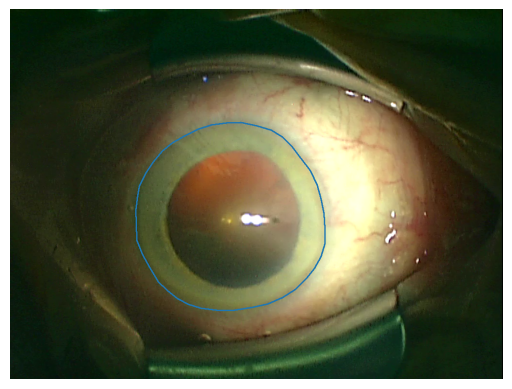

In [ ]:
# https://youtu.be/NYeJvxe5nYw
"""
This code defines a function to display an image with its corresponding annotations.
It reads an image and its associated annotation file in the YOLO v8 text format,
then plots the image along with colored polygons representing the annotated regions.
The polygons are drawn according to the coordinates provided in the annotation file,
and colors are assigned based on the category ID.

"""

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

def display_image_with_annotations(image_path, annotation_path, colors=None):
    # Load image using OpenCV and convert it from BGR to RGB color space
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_h, img_w, _ = image.shape

    # Create a figure and axis to display the image
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    ax.axis('off')  # Turn off the axes

    # Define a default color map if none is provided
    if colors is None:
        colors = plt.cm.get_cmap('tab10')

    # Open the annotation file and process each line
    with open(annotation_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            category_id = int(parts[0])
            # Choose color based on category ID, looping through color map if more than 10 categories
            color = colors(category_id % 10)
            # Extract normalized polygon coordinates and denormalize them
            polygon = [float(coord) for coord in parts[1:]]
            polygon = [coord * img_w if i % 2 == 0 else coord * img_h for i, coord in enumerate(polygon)]
            # Reshape into (num_points, 2) array
            polygon = [(polygon[i], polygon[i+1]) for i in range(0, len(polygon), 2)]
            # Create a Polygon patch using the denormalized coordinates
            patch = patches.Polygon(polygon, closed=True, edgecolor=color, fill=False)
            # Add the patch to the plot to display the annotated region
            ax.add_patch(patch)

    plt.show()  # Display the image with annotations

# Example usage with specified image and annotation paths
image_path = "/content/drive/MyDrive/segmentation yolo/Final dataset with images and labels/images/train/case5015_01.png"
annotation_path = "/content/drive/MyDrive/segmentation yolo/Final dataset with images and labels/labels/train/case5015_01.txt"
display_image_with_annotations(image_path, annotation_path)

# Main part

In [3]:
from ultralytics import YOLO
from matplotlib import pyplot as plt
from PIL import Image

In [4]:
#model = YOLO('yolov8n-seg.yaml')  # build a new model from YAML
model = YOLO('yolov8n-seg.pt')  # Transfer the weights from a pretrained model (recommended for training)

In [5]:
import yaml
with open("/content/drive/MyDrive/segmentation yolo/config.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [6]:
#Define a project --> Destination directory for all results
project = "/content/drive/MyDrive/Capstone/Training Cornea Segmentation/YOLOv8"
#Define subdirectory for this specific training
name = "15-epochs-l4-" #note that if you run the training again, it creates a directory: 200_epochs-2

In [ ]:
# Train the model
results = model.train(data="/content/drive/MyDrive/segmentation yolo/config.yaml",
                      project=project,
                      name=name,
                      epochs=15,
                      patience=0, #I am setting patience=0 to disable early stopping.
                      batch=4,
                      imgsz=512)

Ultralytics 8.3.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/content/drive/MyDrive/segmentation yolo/config.yaml, epochs=15, time=None, patience=0, batch=4, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/Capstone/Training Cornea Segmentation/YOLOv8, name=15-epochs-l4-, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=F

train: Scanning /content/drive/.shortcut-targets-by-id/1rjROKZPA23xNwOZtXk6jL0wNqnmzs13D/segmentation yolo/Final dataset with images and labels/labels/train.cache... 1559 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1559/1559 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/.shortcut-targets-by-id/1rjROKZPA23xNwOZtXk6jL0wNqnmzs13D/segmentation yolo/Final dataset with images and labels/labels/val.cache... 80 images, 0 backgrounds, 0 corrupt: 100%|██████████| 80/80 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/Capstone/Training Cornea Segmentation/YOLOv8/15-epochs-l4-/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/Capstone/Training Cornea Segmentation/YOLOv8/15-epochs-l4-
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/15      0.56G     0.6415     0.9593     0.9207     0.9595          5        512: 100%|██████████| 390/390 [00:38<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  9.62it/s]

                   all         80         80          1          1      0.995      0.852          1          1      0.995      0.919



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/15     0.549G     0.5618     0.6803     0.5448     0.9075          5        512: 100%|██████████| 390/390 [00:35<00:00, 11.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 12.32it/s]

                   all         80         80      0.999          1      0.995      0.873      0.999          1      0.995      0.941



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/15     0.541G     0.5317     0.6392     0.4561     0.8972          7        512: 100%|██████████| 390/390 [00:34<00:00, 11.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 12.44it/s]

                   all         80         80      0.999          1      0.995      0.909      0.999          1      0.995      0.956



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/15     0.562G     0.5121     0.6192     0.4148     0.8987          9        512: 100%|██████████| 390/390 [00:34<00:00, 11.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 12.46it/s]

                   all         80         80      0.999          1      0.995      0.937      0.999          1      0.995      0.969



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/15     0.539G     0.4889     0.5908     0.3643     0.8918          9        512: 100%|██████████| 390/390 [00:34<00:00, 11.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 11.43it/s]

                   all         80         80      0.999          1      0.995      0.922      0.999          1      0.995      0.938


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/15     0.539G     0.3735      0.444      0.291      0.822          3        512: 100%|██████████| 390/390 [00:34<00:00, 11.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 12.96it/s]

                   all         80         80      0.999          1      0.995      0.915      0.999          1      0.995      0.948



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/15     0.539G     0.3587     0.4287     0.2657     0.8162          3        512: 100%|██████████| 390/390 [00:34<00:00, 11.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 13.33it/s]

                   all         80         80      0.999          1      0.995      0.922      0.999          1      0.995      0.942



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/15     0.539G     0.3298     0.4218     0.2378     0.8146          3        512: 100%|██████████| 390/390 [00:34<00:00, 11.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 13.54it/s]

                   all         80         80      0.999          1      0.995      0.928      0.999          1      0.995      0.958



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/15     0.539G     0.3191     0.4169     0.2271     0.7963          3        512: 100%|██████████| 390/390 [00:34<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 12.96it/s]

                   all         80         80      0.999          1      0.995      0.939      0.999          1      0.995       0.96



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/15     0.539G     0.3013     0.3997      0.217     0.7967          3        512: 100%|██████████| 390/390 [00:34<00:00, 11.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 11.94it/s]

                   all         80         80      0.999          1      0.995      0.936      0.999          1      0.995      0.972



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/15     0.539G      0.291     0.3872     0.2046     0.7901          3        512: 100%|██████████| 390/390 [00:35<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 12.66it/s]

                   all         80         80      0.999          1      0.995      0.932      0.999          1      0.995      0.975



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/15     0.539G      0.273     0.3763      0.187     0.7952          3        512: 100%|██████████| 390/390 [00:34<00:00, 11.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 13.05it/s]

                   all         80         80      0.999          1      0.995      0.944      0.999          1      0.995      0.973



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/15     0.539G     0.2584     0.3678     0.1759     0.7844          3        512: 100%|██████████| 390/390 [00:34<00:00, 11.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 13.06it/s]

                   all         80         80      0.999          1      0.995      0.969      0.999          1      0.995      0.982



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/15     0.539G     0.2506     0.3592     0.1675     0.7881          3        512: 100%|██████████| 390/390 [00:34<00:00, 11.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 12.49it/s]

                   all         80         80      0.999          1      0.995      0.956      0.999          1      0.995      0.973



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/15     0.539G     0.2386     0.3513     0.1544     0.7813          3        512: 100%|██████████| 390/390 [00:34<00:00, 11.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 11.14it/s]

                   all         80         80      0.999          1      0.995      0.948      0.999          1      0.995      0.968



15 epochs completed in 0.153 hours.
Optimizer stripped from /content/drive/MyDrive/Capstone/Training Cornea Segmentation/YOLOv8/15-epochs-l4-/weights/last.pt, 6.7MB
Optimizer stripped from /content/drive/MyDrive/Capstone/Training Cornea Segmentation/YOLOv8/15-epochs-l4-/weights/best.pt, 6.7MB

Validating /content/drive/MyDrive/Capstone/Training Cornea Segmentation/YOLOv8/15-epochs-l4-/weights/best.pt...
Ultralytics 8.3.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
YOLOv8n-seg summary (fused): 195 layers, 3,258,259 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:00<00:00, 11.17it/s]


                   all         80         80      0.999          1      0.995      0.969      0.999          1      0.995      0.982
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /content/drive/MyDrive/Capstone/Training Cornea Segmentation/YOLOv8/15-epochs-l4-


# making inference

In [ ]:
my_new_model = YOLO("D:\Capstone\\brinda\Segmentation\\50-epochs-\weights\\best.pt")

In [ ]:
new_image = "D:\Capstone\\brinda\Segmentation\original dataset\\augmented_images\\test\case5335_04_rotate_-10.png"
new_results = my_new_model.predict(new_image, conf=0.2)  #Adjust conf threshold


image 1/1 D:\Capstone\brinda\Segmentation\original dataset\augmented_images\test\case5335_04_rotate_-10.png: 384x512 1 Knife, 105.1ms
Speed: 0.0ms preprocess, 105.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 512)


In [ ]:
new_result_array = new_results[0].plot()
plt.figure(figsize=(12, 12))
plt.imshow(new_result_array)

In [ ]:
new_result = new_results[0]

In [ ]:
new_result

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: ultralytics.engine.results.Masks object
names: {0: 'Knife'}
obb: None
orig_img: array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dty

In [ ]:
plt.figure()
plt.plot([1,2,3])
plt.show()

<Figure size 640x480 with 1 Axes>